In [17]:
# Manipulação e Visualização de Dados
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Scikit-Learn
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc, f1_score, recall_score, classification_report
from scipy.stats import ks_2samp

import optuna

In [18]:
df_train = pd.read_csv('../data/DF_TRAIN.csv')
df_val = pd.read_csv('../data/DF_VAL.csv')
df_test = pd.read_csv('../data/DF_TEST.csv')

In [19]:
TARGET = "Churn"

X_train, y_train = df_train.drop(columns=[TARGET]), df_train[TARGET]
X_val,   y_val   = df_val.drop(columns=[TARGET]),   df_val[TARGET]
X_test,  y_test  = df_test.drop(columns=[TARGET]),  df_test[TARGET]

In [20]:
# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_val)
print("Acurácia Random Forest (validação):", accuracy_score(y_val, rf_preds))

# MLPClassifier
mlp_model = MLPClassifier(random_state=42,max_iter=1000)
mlp_model.fit(X_train, y_train)
mlp_preds = mlp_model.predict(X_val)
print("Acurácia MLP (validação):", accuracy_score(y_val, mlp_preds))

# XGBoost
from xgboost import XGBClassifier

xgb_model = XGBClassifier(random_state=42, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_val)
print("Acurácia XGBoost (validação):", accuracy_score(y_val, xgb_preds))

Acurácia Random Forest (validação): 0.7463322290582111
Acurácia MLP (validação): 0.7397065783246569
Acurácia XGBoost (validação): 0.7496450544249882


In [ ]:
import warnings


def compute_metric(metric, y_true, probs, preds):
    """
    Calcula o score de acordo com a métrica escolhida.
    
    Parâmetros:
      - metric: string ('ks', 'roc', 'accuracy', 'f1', 'recall')
      - y_true: valores reais
      - probs: probabilidades preditas (usadas para KS e ROC-AUC)
      - preds: classes preditas (usadas para acurácia, F1 e recall)
      
    Retorna:
      - Valor da métrica escolhida.
    """
    if metric == 'ks':
        return ks_2samp(probs[y_true == 1], probs[y_true == 0]).statistic
    elif metric == 'roc':
        fpr, tpr, thresholds = roc_curve(y_true, probs)
        return auc(fpr, tpr)
    elif metric == 'accuracy':
        return accuracy_score(y_true, preds)
    elif metric == 'f1':
        return f1_score(y_true, preds)
    elif metric == 'recall':
        return recall_score(y_true, preds)
    else:
        raise ValueError("Métrica não suportada. Escolha entre 'ks', 'roc', 'accuracy', 'f1' ou 'recall'.")

def get_objective(model_name, metric='ks'):
    """
    Retorna uma função objetivo para o modelo especificado com a métrica desejada.
    
    Parâmetros:
      - model_name: string ('rf', 'mlp' ou 'xgb')
      - metric: string, métrica a ser otimizada.
    """
    def objective(trial):
        if model_name == 'rf':
            # Hiperparâmetros para Random Forest
            n_estimators = trial.suggest_int('n_estimators', 50, 300)
            max_depth = trial.suggest_int('max_depth', 2, 80, log=True)
            min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
            min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
            max_features = trial.suggest_float('max_features', 0.1, 1.0)
            bootstrap = trial.suggest_categorical('bootstrap', [True, False])
            criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
            
            clf = RandomForestClassifier(
                n_estimators=n_estimators,
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                min_samples_leaf=min_samples_leaf,
                max_features=max_features,
                bootstrap=bootstrap,
                criterion=criterion,
                random_state=42
            )
            
        elif model_name == 'mlp':
            # Hiperparâmetros para MLPClassifier
            hidden_layer_sizes = trial.suggest_categorical(
                'hidden_layer_sizes', 
                [(50,), (100,), (50, 50), (100, 50), (100, 100)]
            )
            activation = trial.suggest_categorical('activation', ['relu', 'tanh', 'logistic'])
            solver = trial.suggest_categorical('solver', ['adam', 'sgd'])
            alpha = trial.suggest_float('alpha', 1e-5, 1e-2, log=True)
            learning_rate_init = trial.suggest_float('learning_rate_init', 1e-7, 1e-1, log=True)
            batch_size = trial.suggest_categorical('batch_size', ['auto', 8, 16, 32, 64, 128])
            max_iter = trial.suggest_categorical('max_iter', [100, 300, 500, 1000])
            
            clf = MLPClassifier(
                hidden_layer_sizes=hidden_layer_sizes,
                activation=activation,
                solver=solver,
                alpha=alpha,
                learning_rate_init=learning_rate_init,
                batch_size=batch_size,
                max_iter=max_iter,
                random_state=42
            )
            
        elif model_name == 'xgb':
            # Hiperparâmetros para XGBoost
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 50, 300),
                'max_depth': trial.suggest_int('max_depth', 2, 10, log=True),
                'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
                'gamma': trial.suggest_float('gamma', 0, 5),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
                'reg_alpha': trial.suggest_float('reg_alpha', 1e-5, 1e-1, log=True),
                'reg_lambda': trial.suggest_float('reg_lambda', 1e-5, 1e-1, log=True)
            }
            
            clf = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', **params)
        else:
            raise ValueError("Modelo não suportado. Escolha 'rf', 'mlp' ou 'xgb'.")
        
        clf.fit(X_train, y_train)
        probs = clf.predict_proba(X_val)[:, 1]
        preds = clf.predict(X_val)
        score = compute_metric(metric, y_val, probs, preds)
        return score

    return objective

# # Escolha a métrica desejada: 'ks', 'roc', 'accuracy', 'f1' ou 'recall'
# metric_escolhida = 'ks'

# # Otimização para Random Forest
# study_rf = optuna.create_study(direction='maximize')
# study_rf.optimize(get_objective('rf', metric=metric_escolhida), n_trials=50)

# best_rf_params = study_rf.best_params
# print("Melhores parâmetros para Random Forest:", study_rf.best_params)
# print("Melhor {} (Random Forest):".format(metric_escolhida), study_rf.best_value)
# # Otimização para MLPClassifier
# study_mlp = optuna.create_study(direction='maximize')
# study_mlp.optimize(get_objective('mlp', metric=metric_escolhida), n_trials=50)

# best_mlp_params = study_mlp.best_params
# print("Melhores parâmetros para MLP:", study_mlp.best_params)
# print("Melhor {} (MLP):".format(metric_escolhida), study_mlp.best_value)

# # Otimização para XGBoost
# study_xgb = optuna.create_study(direction='maximize')
# study_xgb.optimize(get_objective('xgb', metric=metric_escolhida), n_trials=50)

# best_xgb_params = study_xgb.best_params
# print("Melhores parâmetros para XGBoost:", study_xgb.best_params)
# print("Melhor {} (XGBoost):".format(metric_escolhida), study_xgb.best_value)

# # Suprimir warnings e logs do Optuna (caso deseje)
# warnings.filterwarnings("ignore", category=UserWarning)
# optuna.logging.set_verbosity(optuna.logging.ERROR)
# optuna.logging.disable_default_handler()

Melhores parâmetros para Random Forest: {'n_estimators': 112, 'max_depth': 6, 'min_samples_split': 16, 'min_samples_leaf': 13, 'max_features': 0.3883136059492759, 'bootstrap': False, 'criterion': 'gini'}
Melhor ks (Random Forest): 0.5098908803075706
Melhores parâmetros para MLP: {'hidden_layer_sizes': (50,), 'activation': 'relu', 'solver': 'adam', 'alpha': 5.69947811325356e-05, 'learning_rate_init': 1.834518967732375e-05, 'batch_size': 8, 'max_iter': 300}
Melhor ks (MLP): 0.5112500706733759
Melhores parâmetros para XGBoost: {'n_estimators': 123, 'max_depth': 4, 'learning_rate': 0.03010163674923011, 'gamma': 3.7749216056289603, 'subsample': 0.8771327973135544, 'colsample_bytree': 0.702942689042824, 'reg_alpha': 0.0134570279489511, 'reg_lambda': 0.00010324932901721255}
Melhor ks (XGBoost): 0.5242008254650308


In [ ]:
best_rf_params = {'n_estimators': 112, 'max_depth': 6, 'min_samples_split': 16, 'min_samples_leaf': 13, 'max_features': 0.3883136059492759, 'bootstrap': False, 'criterion': 'gini'}
best_mlp_params = {'hidden_layer_sizes': (50,), 'activation': 'relu', 'solver': 'adam', 'alpha': 5.69947811325356e-05, 'learning_rate_init': 1.834518967732375e-05, 'batch_size': 8, 'max_iter': 300}
best_xgb_params =  {'n_estimators': 123, 'max_depth': 4, 'learning_rate': 0.03010163674923011, 'gamma': 3.7749216056289603, 'subsample': 0.8771327973135544, 'colsample_bytree': 0.702942689042824, 'reg_alpha': 0.0134570279489511, 'reg_lambda': 0.00010324932901721255}

In [22]:
from matplotlib import pyplot as plt


def plot_ks(probabilities, y_true, model_name):
    """
    Plota a curva KS para um modelo.
    
    Parâmetros:
    - probabilities: array com as probabilidades preditas para a classe positiva.
    - y_true: array/Series com os rótulos reais.
    - model_name: nome do modelo (string) para identificação no gráfico.
    """
    # Separar probabilidades para as classes 1 (positiva) e 0 (negativa)
    pos_probs = probabilities[y_true == 1]
    neg_probs = probabilities[y_true == 0]
    
    # Definir os thresholds (pontos de corte) como os valores únicos preditos
    thresholds = np.sort(np.unique(np.concatenate((pos_probs, neg_probs))))
    
    # Calcular as CDFs empíricas para cada grupo
    pos_cdf = [np.mean(pos_probs <= t) for t in thresholds]
    neg_cdf = [np.mean(neg_probs <= t) for t in thresholds]
    
    # Calcular a diferença absoluta entre as duas CDFs e identificar o máximo
    differences = np.abs(np.array(pos_cdf) - np.array(neg_cdf))
    ks_stat = np.max(differences)
    ks_index = np.argmax(differences)
    ks_threshold = thresholds[ks_index]
    
    # Plotar as CDFs
    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, pos_cdf, label=f'{model_name} - Classe 1 (Positivo)')
    plt.plot(thresholds, neg_cdf, label=f'{model_name} - Classe 0 (Negativo)')
    plt.axvline(x=ks_threshold, color='red', linestyle='--', 
                label=f'KS = {ks_stat:.2f} (limiar = {ks_threshold:.2f})')
    plt.xlabel('Probabilidade predita')
    plt.ylabel('CDF')
    plt.title(f'Curva KS para {model_name}')
    plt.legend(loc='best')
    plt.show()

Final Random Forest Test Accuracy: 0.779460482725982
Final MLP Test Accuracy: 0.7681022243256034
Final XGBoost Test Accuracy: 0.7846663511594889
XGBoost Test F1 Score: 0.6242774566473989
XGBoost Test Recall: 0.6923076923076923
############################


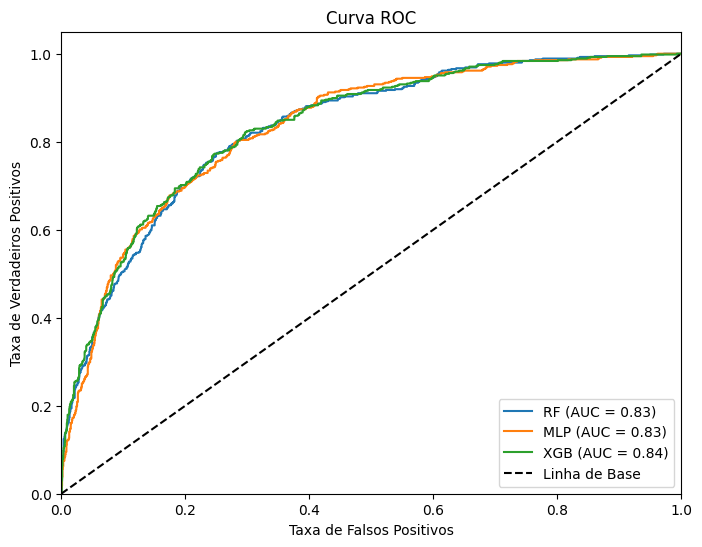

KS Statistic Random Forest: 0.5232894100156384
KS Statistic MLP: 0.5183816396324373
KS Statistic XGBoost: 0.5253698651911798


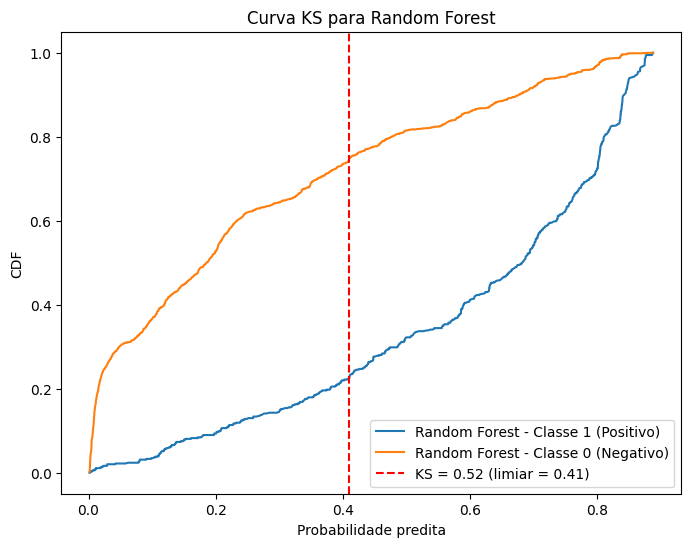

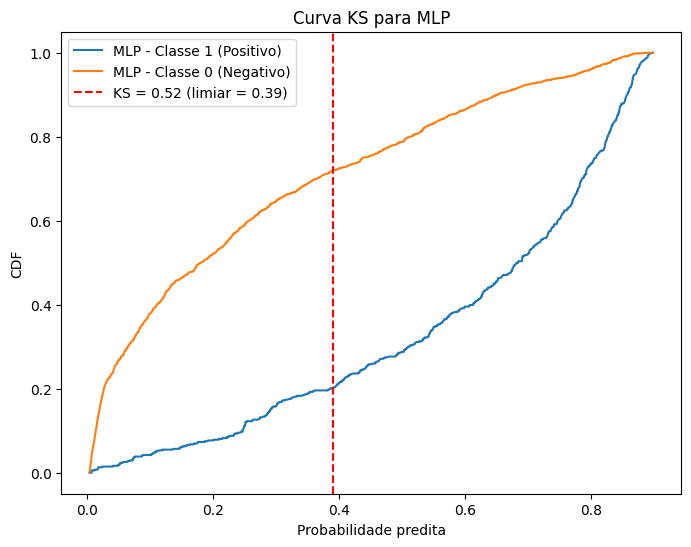

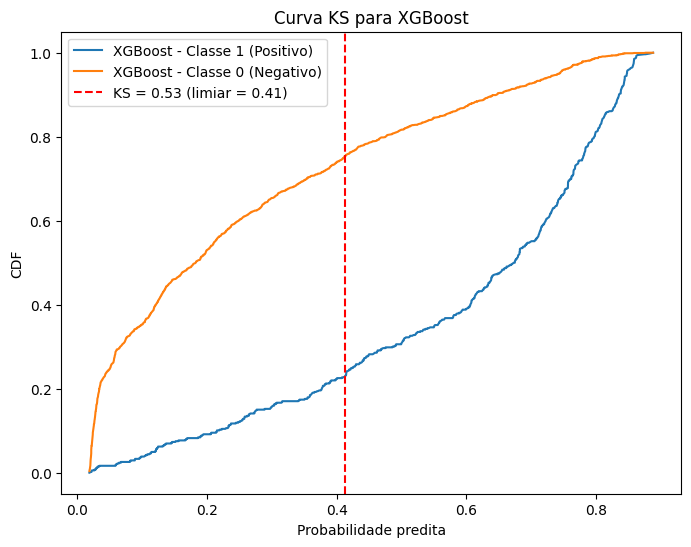

In [23]:
# Combinar os conjuntos de treino e validação para treinar o modelo final
X_train_df = pd.DataFrame(X_train)
X_valid_df = pd.DataFrame(X_val)
X_train_final = pd.concat([X_train_df, X_valid_df], axis=0)

y_train_df = pd.DataFrame(y_train)
y_valid_df = pd.DataFrame(y_val)
y_train_final = pd.concat([y_train_df, y_valid_df], axis=0)

# --- Modelo Final: Random Forest ---
final_rf_model = RandomForestClassifier(random_state=42, **best_rf_params)
final_rf_model.fit(X_train_final, y_train_final)
rf_test_preds = final_rf_model.predict(X_test)
rf_test_accuracy = accuracy_score(y_test, rf_test_preds)
print("Final Random Forest Test Accuracy:", rf_test_accuracy)

# --- Modelo Final: MLPClassifier ---
final_mlp_model = MLPClassifier(random_state=42, **best_mlp_params)
final_mlp_model.fit(X_train_final, y_train_final)
mlp_test_preds = final_mlp_model.predict(X_test)
mlp_test_accuracy = accuracy_score(y_test, mlp_test_preds)
print("Final MLP Test Accuracy:", mlp_test_accuracy)

# --- Modelo Final: XGBoost ---
final_xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', **best_xgb_params)
final_xgb_model.fit(X_train_final, y_train_final)
xgb_test_preds = final_xgb_model.predict(X_test)
xgb_test_accuracy = accuracy_score(y_test, xgb_test_preds)
print("Final XGBoost Test Accuracy:", xgb_test_accuracy)
# Para métricas baseadas em probabilidades, obtemos as probabilidades da classe positiva:
xgb_probs = final_xgb_model.predict_proba(X_test)[:, 1]
# Se necessário, defina pos_label para as métricas F1/Recall, aqui supomos "Yes"
xgb_f1 = f1_score(y_test, xgb_test_preds, pos_label=1)
xgb_recall = recall_score(y_test, xgb_test_preds, pos_label=1)
print("XGBoost Test F1 Score:", xgb_f1)
print("XGBoost Test Recall:", xgb_recall)
print("############################")

# --- Avaliação com Curva ROC e KS Statistic ---
# Obter probabilidades preditas para a classe positiva ("Yes")
rf_probs = final_rf_model.predict_proba(X_test)[:, 1]
mlp_probs = final_mlp_model.predict_proba(X_test)[:, 1]
# (xgb_probs já foi obtido acima)

# Curva ROC para Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs, pos_label=1)
roc_auc_rf = auc(fpr_rf, tpr_rf)
# Curva ROC para MLP
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, mlp_probs, pos_label=1)
roc_auc_mlp = auc(fpr_mlp, tpr_mlp)
# Curva ROC para XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_probs, pos_label=1)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plotar as curvas ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f'RF (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_mlp, tpr_mlp, label=f'MLP (AUC = {roc_auc_mlp:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGB (AUC = {roc_auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Linha de Base')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

# Cálculo do KS Statistic (comparando as probabilidades entre 1 e 0)
ks_rf = ks_2samp(rf_probs[y_test == 1], rf_probs[y_test == 0]).statistic
ks_mlp = ks_2samp(mlp_probs[y_test == 1], mlp_probs[y_test == 0]).statistic
ks_xgb = ks_2samp(xgb_probs[y_test == 1], xgb_probs[y_test == 0]).statistic

print("KS Statistic Random Forest:", ks_rf)
print("KS Statistic MLP:", ks_mlp)
print("KS Statistic XGBoost:", ks_xgb)

plot_ks(rf_probs, y_test, 'Random Forest')
plot_ks(mlp_probs, y_test, 'MLP')
plot_ks(xgb_probs, y_test, 'XGBoost')

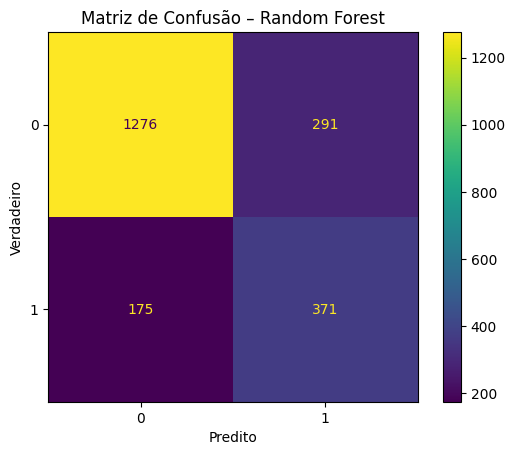

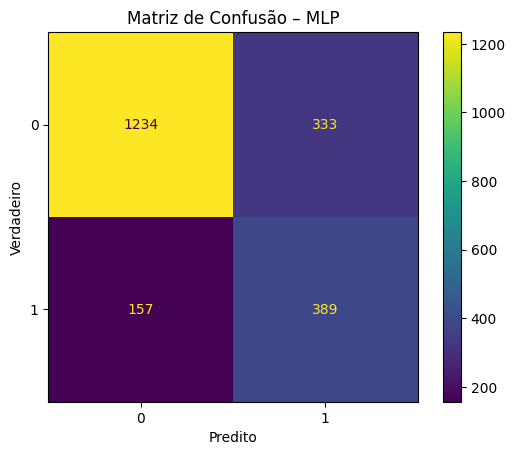

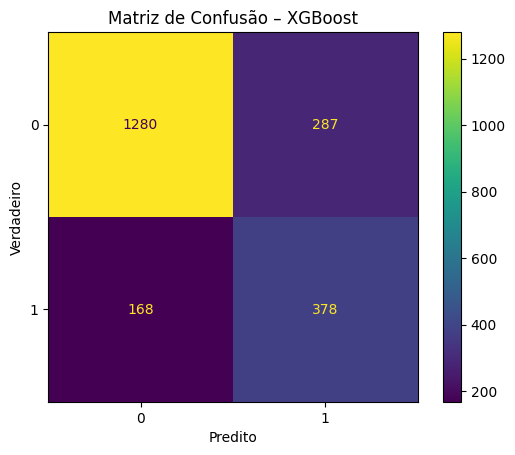

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# supondo que você já tenha:
# rf_test_preds, mlp_test_preds, xgb_test_preds
# y_test

# dicionário com rótulos e previsões
results = {
    "Random Forest": rf_test_preds,
    "MLP":           mlp_test_preds,
    "XGBoost":       xgb_test_preds
}

for name, preds in results.items():
    # calcula matriz de confusão
    cm = confusion_matrix(y_test, preds, labels=[0, 1])
    
    # plota
    fig, ax = plt.subplots()
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(ax=ax)
    
    ax.set_title(f"Matriz de Confusão – {name}")
    plt.xlabel("Predito")
    plt.ylabel("Verdadeiro")
    plt.show()
